In [1]:
import pandas as pd
import numpy as np

In [2]:
## Stock Split on GOOGL UW (Alphabet Inc. -A-). The 20 for 1 stock split was adjusted.
2461.48 / 20, 5000 / (2461.48 / 20)

(123.074, 40.62596486666558)

## Basic descriptions

In [3]:
denomination = 5000
barrier = 0.59
# being the date on which the Strike and the Barrier and the Ratio is fixed,
# and from which date the Complex Products may be traded
initial_fixing_date = "2022-04-25" 
final_fixing_date = "2023-07-26"
final_redemption_date = "2023-08-02"

issue_date = "2022-05-02"

coupon_rate = 0.11 / 4

coupon_payment_dates = [
    "2022-08-02",
    "2022-11-02",
    "2023-02-02",
    "2023-05-02",
    "2023-08-02"
]

early_redemption_dates = [
    "2022-11-02",
    "2023-02-02",
    "2023-05-02"
]

stock_init_price = {
    "GOOGL":  2461.48 / 20,
    "AAPL": 162.88,
    "MSFT": 280.72
}

stock_ratio = {
    "GOOGL":  40.62596486666558,
    "AAPL": 30.6974,
    "MSFT": 17.8113
}


In [4]:
## config
log = True

## Count Business days

In [5]:
def get_business_days_from_initial_date(cur_date, initial_date = issue_date):
    return np.busday_count(initial_date, cur_date)

def get_business_days_to_final_redemption(cur_date, final_date = final_redemption_date):
    return np.busday_count(cur_date, final_date)

In [6]:
print("coupon_payment_dates")
for date in coupon_payment_dates:
    print(date, ": ", get_business_days_from_initial_date(date))
    print("dates to marutre: ", get_business_days_to_final_redemption(date))

print("early_redemption_dates")
for date in early_redemption_dates:
    print(date, ": ", get_business_days_from_initial_date(date))
    print("dates to marutre: ", get_business_days_to_final_redemption(date))

coupon_payment_dates
2022-08-02 :  66
dates to marutre:  261
2022-11-02 :  132
dates to marutre:  195
2023-02-02 :  198
dates to marutre:  129
2023-05-02 :  261
dates to marutre:  66
2023-08-02 :  327
dates to marutre:  0
early_redemption_dates
2022-11-02 :  132
dates to marutre:  195
2023-02-02 :  198
dates to marutre:  129
2023-05-02 :  261
dates to marutre:  66


## Caculate interest rate discounted price

In [7]:
## dummy intesest rate func 
# (should return the average interest rate from current date to final redemption date)
def get_interest_rate(cur_date, to_date = final_redemption_date):
    return 0.03

def get_discounted_price(p: float, cur_date, to_date = final_redemption_date):
    r = get_interest_rate(cur_date)
    return p * np.exp(- r * np.busday_count(cur_date, to_date) / 250)

In [8]:
## simple test: how much is $100 one year later worth today?
get_discounted_price(100, "2022-11-07", "2023-11-07")

96.91653905244968

In [9]:
## p_mature should be the lowest total price of stocks
def get_product_price(p_mature, cur_date):
    coupon_remaining = 0.0
    for coupon_payment_date in coupon_payment_dates:
        if cur_date <= coupon_payment_date:
            coupon_remaining += get_discounted_price(denomination * coupon_rate, cur_date, coupon_payment_date)
    d = get_discounted_price(p_mature, cur_date, final_redemption_date)
    return d + coupon_remaining


In [10]:
## How much is 5000 + 11% quarterly worth on issue_date?
get_product_price(5000, issue_date)

5479.09477960645

In [11]:
5000 * (1 + 0.11 * 1.5)

5825.0

## Redemption Amount

In [12]:
df_init_price = pd.Series(stock_init_price)
df_convert = pd.Series(stock_ratio)
df_init_price, df_convert


(GOOGL    123.074
 AAPL     162.880
 MSFT     280.720
 dtype: float64,
 GOOGL    40.625965
 AAPL     30.697400
 MSFT     17.811300
 dtype: float64)

In [13]:
## input: 
stock_names = ["GOOGL", "AAPL", "MSFT"]

def get_redemption_amount(df: pd.DataFrame):
    lowest_prices = df[stock_names].min()
    barrier_trigger = (lowest_prices / df_init_price < barrier).sum() 

    # if log:
    #     print("barrier_trigger", barrier_trigger)

    if barrier_trigger > 0:
        tmpdf = df.reset_index().set_index("date")
        stock_min = (tmpdf.loc[tmpdf.index.max(), stock_names] * df_convert).min()
        if log:
            print("stock_min", stock_min)
        return min(stock_min, denomination)
    else:
        return denomination


In [14]:
sample_path_df = pd.read_csv("../generated_data/sample_path.csv", index_col = "date")
df = sample_path_df
df

,GOOGL,MSFT,AAPL
date,,,
2022-07-22,113.602065,262.053037,153.942500
2022-07-25,114.735530,264.850739,155.106186
2022-07-26,111.220134,254.515022,148.911027
2022-07-27,108.008860,247.503351,144.744386
2022-07-28,103.235604,235.304339,137.725854
...,...,...,...
2023-07-20,74.088786,182.356124,127.010467
2023-07-21,73.337796,179.753237,126.103559
2023-07-24,68.467933,168.802990,117.956346


In [15]:
get_redemption_amount(sample_path_df)

stock_min 2698.115894502515


2698.115894502515

In [16]:
get_product_price(get_redemption_amount(sample_path_df), cur_date = sample_path_df.index.min())

stock_min 2698.115894502515


3288.9911854453044

In [17]:
3363.8576424803377 / 5000

0.6727715284960676

## Callable Feature

In [18]:
sample_sim_1000 = pd.read_csv("../generated_data/sample_sim_1000.csv", index_col=["index", "date"])
sample_sim_1000.reset_index(inplace=True)
sample_sim_1000 

,index,date,GOOGL,MSFT,AAPL
0,0,2022-07-22,117.267965,271.399743,159.268246
1,0,2022-07-25,119.411379,275.630014,162.301010
2,0,2022-07-26,129.039037,294.960545,174.422211
3,0,2022-07-27,130.341209,296.704695,175.893058
4,0,2022-07-28,134.040499,305.881652,181.046765
...,...,...,...,...,...
263995,999,2023-07-20,64.465660,154.336144,102.588336
263996,999,2023-07-21,67.082320,160.528711,106.895751
263997,999,2023-07-24,67.524835,160.637920,107.350989
263998,999,2023-07-25,70.353116,167.628150,111.731851


In [19]:
import statsmodels.api as sm

In [20]:
## y = a_0 + a_1 * x + a_2 * x ** 2
class Poly2DModel:
    
    mod: sm.OLS
    x_name: str
    
    def fit(self, df : pd.DataFrame, x_names: list, y_name: str):
        self.x_names = x_names
        self.df = df
        for x_name in self.x_names:
            self.df[x_name + "_sq"] = np.power(self.df[x_name], 2)
        
        self.x_names.extend([x_name + "_sq" for x_name in self.x_names])
            
        self.X = sm.add_constant(self.df[self.x_names])
        self.y = self.df[y_name]
        self.mod = sm.OLS(self.y, self.X).fit()

    def predict(self):
        self.df["pred"] = self.mod.predict()
        return self.mod.predict()

In [21]:
test_df = (
    sample_sim_1000[((sample_sim_1000["date"] == "2023-07-26") | (sample_sim_1000["date"] == "2022-08-02"))]
    [["index", "date", "GOOGL"]]
    .pivot(index = "index", columns = "date", values = "GOOGL")
)

<AxesSubplot:xlabel='2022-08-02', ylabel='pred'>

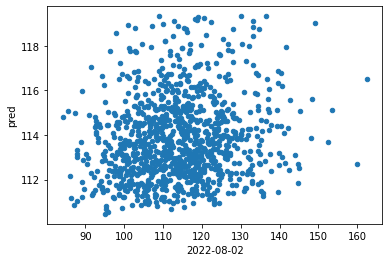

In [22]:
mod = Poly2DModel()
mod.fit(test_df, x_names = ["2023-07-26"], y_name="2022-08-02")
mod.predict()
mod.df.plot(x = "2022-08-02", y = "pred", kind= "scatter")

In [23]:
def get_sim_noncallable_price(df: pd.DataFrame):
    func_df = df.set_index(["index", "date"])
    l = []
    for i in  range(1000):
        tmp_df = func_df.loc[i]
        l.append(get_product_price(get_redemption_amount(tmp_df), cur_date = tmp_df.index.max()))
        
    return pd.Series(l, index = pd.Series([x for x in range(1000)]))

In [24]:
final_prices = get_sim_noncallable_price(sample_sim_1000)

stock_min 2032.6096787345173
stock_min 719.2995683453214
stock_min 2822.025881219722
stock_min 2078.6876695570827
stock_min 5726.205381652478
stock_min 3603.067035814698
stock_min 2032.8038883433017
stock_min 1011.8651643066936
stock_min 1504.1525735478265
stock_min 1519.9818619917917
stock_min 2117.519782640338
stock_min 2570.550232529802
stock_min 1684.4192189815287
stock_min 3831.9891332825405
stock_min 2656.2121402609105
stock_min 3963.1093768808864
stock_min 1320.6756515227698
stock_min 2717.086344234062
stock_min 1569.0741602096864
stock_min 1340.4707845165822
stock_min 3641.110041832655
stock_min 1613.2977196371307
stock_min 1906.946435842405
stock_min 2839.8552103683346
stock_min 1996.3846945712526
stock_min 1893.9961369445004
stock_min 2588.0991194081234
stock_min 491.72078582238305
stock_min 2811.5656852895017
stock_min 1762.8071357932386
stock_min 2292.5519258738886
stock_min 1266.9941543221278
stock_min 2626.8382616488675
stock_min 2065.6022470968505
stock_min 806.031586688

In [25]:
final_prices

0      5134.418425
1      2168.808003
2      5134.418425
3      5134.418425
4      5134.418425
          ...     
995    1006.613788
996    5134.418425
997    2787.169016
998    5134.418425
999    2990.623652
Length: 1000, dtype: float64